# Importing relevent libraries

In [1]:
import numpy as np
import tensorflow as tf
#We need the tensorflow-datasets module, therefore, if you haven't please install the package using
# pip install tensorflow-datasets 
# or
# conda install tensorflow-datasets

import tensorflow_datasets as tfds

# Data

In [2]:
mnist_dataset, mnist_info=tfds.load(name='mnist',with_info=True,as_supervised=True)

# Explore the data

In [3]:
mnist_dataset

{'test': <PrefetchDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>,
 'train': <PrefetchDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>}

# Split

In [4]:
mnist_train,mnist_test=mnist_dataset['train'],mnist_dataset['test']

In [5]:
#Further splitting to get Validation Set

In [6]:
num_validation_samples=0.1*mnist_info.splits['train'].num_examples     #Using mnist_info to split training set
num_validation_samples=tf.cast(num_validation_samples, tf.int64)      #tf.cast convert the variable into int64 data type

In [7]:
num_test_samples=mnist_info.splits['test'].num_examples
prev=num_test_samples
num_test_samples=tf.cast(num_test_samples, tf.int64)          #convert from int to numpy int64

In [8]:
prev

10000

In [9]:
num_test_samples

<tf.Tensor: shape=(), dtype=int64, numpy=10000>

# Preprocessing

## Feature Scaling

In [10]:
#we would like to scale\transform\resize the data in such a way that their input hace equal effect on weights(coefficients)
# or we can say it is to make the result more numerically stable
# in this case we will simply prefer to have inputs between 0 and 1
def scale(image, label):
    # we make sure the value is a float
    image = tf.cast(image, tf.float32)
    # since the possible values for the inputs are 0 to 255 (256 different shades of grey)
    # if we divide each element by 255, we would get the desired result -> all elements will be between 0 and 1 
    image /= 255.

    return image, label


In [11]:
scaled_train_and_validation_data=mnist_train.map(scale)  #dataset.map(function) applies custom transformation to a dataset. 
                                                         #Take function as a input which define transformation

In [12]:
scaled_train_and_validation_data

<MapDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>

In [13]:
#Scaling Test dataset so it has the same scale as train and validation data
test_data=mnist_test.map(scale)

In [14]:
test_data

<MapDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>

## Shuffle and Batch

In [15]:
#SHUFFLE
# this BUFFER_SIZE parameter is here for cases when we're dealing with enormous datasets
# then we can't shuffle the whole dataset in one go because we can't fit it all in memory
# so instead TF only stores BUFFER_SIZE samples in memory at a time and shuffles them
# if BUFFER_SIZE=1 => no shuffling will actually happen
# if BUFFER_SIZE >= num samples => shuffling is uniform
# BUFFER_SIZE in between - a computational optimization to approximate uniform shuffling

BUFFER_SIZE = 10000

shuffled_train_and_validation_data = scaled_train_and_validation_data.shuffle(BUFFER_SIZE)

validation_data = shuffled_train_and_validation_data.take(num_validation_samples) #.take() method will take that same number 
                                                                                  #of samples as in num_validation_samples
train_data=shuffled_train_and_validation_data.skip(num_validation_samples)    #Skip the no. of samples in 
                                                                              #num_validation_samples

In [16]:
#Batch
BATCH_SIZE = 250                          #one batch include 100/60000 observations

train_data = train_data.batch(BATCH_SIZE)

validation_data = validation_data.batch(num_validation_samples)  #No Batching done for validation set

test_data = test_data.batch(num_test_samples)                    #No batching for test set also


#To make the validation_data to have same format and feature as train and test data
# because as_supervized=True, we've got a 2-tuple structure
validation_inputs, validation_targets = next(iter(validation_data))

# MODEL

## Outline the Model

In [17]:
input_size=784
output_size=10
hidden_layer_size=200      #U can choose the hidden layer of different sizes
model = tf.keras.Sequential([    #Sequetial used to stack layers
                                 #Flatten used to convert tensor into vector   
            tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
                             
                             #Dense used to build each layer 
                             #It calculates dot product and here we apply activation function                             
            tf.keras.layers.Dense(hidden_layer_size,activation='relu'),  #Layer 1
            tf.keras.layers.Dense(hidden_layer_size,activation='relu'),  #Layer 2
            tf.keras.layers.Dense(hidden_layer_size,activation='relu'),  #Layer 3
    
    
            tf.keras.layers.Dense(output_size,activation='softmax')  #Output layer with probabilities(softmax)
])

# Objective Function

## Choose the Optimizer and the Loss Function

In [18]:
#custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Training

In [20]:
%load_ext tensorboard

In [21]:
import datetime

In [22]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [23]:
NUM_EPOCHS = 50

digit=model.fit(train_data, epochs=NUM_EPOCHS, validation_data=(validation_inputs, validation_targets), verbose=2,callbacks=[tensorboard_callback])

Epoch 1/50
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


216/216 - 3s - loss: 0.3495 - accuracy: 0.9000 - val_loss: 0.1444 - val_accuracy: 0.9573
Epoch 2/50
216/216 - 2s - loss: 0.1271 - accuracy: 0.9619 - val_loss: 0.1033 - val_accuracy: 0.9690
Epoch 3/50
216/216 - 2s - loss: 0.0826 - accuracy: 0.9744 - val_loss: 0.0740 - val_accuracy: 0.9782
Epoch 4/50
216/216 - 2s - loss: 0.0614 - accuracy: 0.9809 - val_loss: 0.0635 - val_accuracy: 0.9792
Epoch 5/50
216/216 - 2s - loss: 0.0464 - accuracy: 0.9860 - val_loss: 0.0465 - val_accuracy: 0.9853
Epoch 6/50
216/216 - 2s - loss: 0.0371 - accuracy: 0.9882 - val_loss: 0.0487 - val_accuracy: 0.9853
Epoch 7/50
216/216 - 2s - loss: 0.0303 - accuracy: 0.9902 - val_loss: 0.0513 - val_accuracy: 0.9838
Epoch 8/50
216/216 - 2s - loss: 0.0267 - accuracy: 0.9914 - val_loss: 0.0332 - val_accuracy: 0.9895
Epoch 9/50
216/216 - 2s - loss: 0.0203 - accuracy: 0.9935 - val_loss: 0.0252 - val_accuracy: 0.9917
Epoch 10/50
216/216 - 2s - loss: 0.0172 - accuracy: 0.9947 - val_loss: 0.0256 - val_accuracy: 0.9915
Epoch 11/5

In [24]:
test_loss, test_accuracy = model.evaluate(test_data)

1/1 [==============================] - 0s 1ms/step - loss: 0.1167 - accuracy: 0.9809


In [25]:
valid_loss, valid_accuracy = model.evaluate(validation_data)

1/1 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 0.9983


In [26]:
# We can apply some nice formatting if we want to
print('Test loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

Test loss: 0.12. Test accuracy: 98.09%


In [27]:
print(digit.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [28]:
digit.history['accuracy']

[0.8999999761581421,
 0.9618518352508545,
 0.9743703603744507,
 0.9809073805809021,
 0.985962986946106,
 0.9882407188415527,
 0.990240752696991,
 0.9913889169692993,
 0.9935185313224792,
 0.9947222471237183,
 0.9952222108840942,
 0.9955740571022034,
 0.9944074153900146,
 0.9958148002624512,
 0.99529629945755,
 0.9965000152587891,
 0.9958518743515015,
 0.9966481328010559,
 0.9963889122009277,
 0.9970555305480957,
 0.9948333501815796,
 0.9978703856468201,
 0.9988703727722168,
 0.9987407326698303,
 0.9967963099479675,
 0.9976666569709778,
 0.9969815015792847,
 0.9970370531082153,
 0.9980740547180176,
 0.9973888993263245,
 0.9972962737083435,
 0.9984444379806519,
 0.9988148212432861,
 0.9987221956253052,
 0.996833324432373,
 0.9978888630867004,
 0.9976111054420471,
 0.9990370273590088,
 0.9992777705192566,
 0.9992592334747314,
 0.9985740780830383,
 0.9969074130058289,
 0.9982222318649292,
 0.9988889098167419,
 0.9994814991950989,
 0.998629629611969,
 0.9969074130058289,
 0.9984259009361267

In [29]:
from matplotlib import pyplot as plt

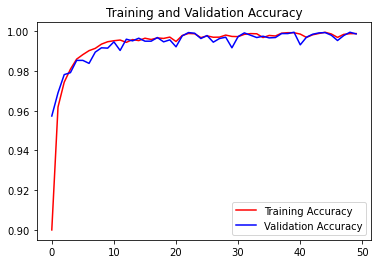

In [30]:
plt.plot(digit.history['accuracy'],c='red',label='Training Accuracy')
plt.plot(digit.history['val_accuracy'],c='blue',label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)


In [32]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 4884), started 0:01:49 ago. (Use '!kill 4884' to kill it.)